In [1]:
import pandas as pd

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os

In [4]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing

In [5]:
def convert_to_vect(Q,R,S,T):
    resp=np.empty((0,4))
    end:Boolean= False
    idx_q=0    
    idx_r=0
    idx_s=0
    idx_t=0

    
    while not end:
        try:
            q=Q[idx_q]
            r=R[idx_r]
            s=S[idx_s]
            t=T[idx_t]
        except IndexError:
                end=True
                pass    
       
        arr=np.array([q,r,s,t],dtype=int)
        if not (q <= r and  r <=s and s <=t) :#and q < x_complex and t > x_complex :
            arr=np.array([-1,-1,-1,-1],dtype=int)
            print("no")
            
        else:
            resp=np.vstack((resp,arr))           
            
        if idx_q+1<len(Q):
            idx_q=idx_q+1
        else:
            end=True
        if   idx_r+1<len(R):        
            idx_r=idx_r+1
        else:
            end=True    
        if   idx_s+1<len(S):        
            idx_s=idx_s+1
        else:
            end= True
        if   idx_t+1<len(S):        
            idx_t=idx_t+1
        else:
            end= True    
    return resp

In [6]:
files= os.listdir('./data/processed.old/')

In [7]:
files

['107-113-p000107-2121-11-30-20-03-False.plk',
 '109-129-p000109-2141-10-21-02-00-False.plk',
 '109-148-p000109-2142-08-13-05-59-False.plk',
 '123-165-p000123-2161-10-29-03-01-False.plk',
 '124-169-p000124-2166-01-23-10-43-True.plk',
 '154-206-p000154-2127-12-23-22-02-False.plk',
 '160-214-p000160-2174-11-06-10-12-False.plk',
 '188-251-p000188-2161-12-09-17-50-True.plk',
 '188-251-p000188-2162-01-10-18-53-True.plk',
 '20-18-p000020-2183-04-28-17-47-False.plk',
 '208-272-p000208-2188-05-18-00-06-False.plk',
 '222-290-p000222-2142-06-26-16-08-False.plk',
 '301-382-p000301-2189-11-11-09-04-False.plk',
 '308-394-p000308-2135-09-04-12-57-False.plk',
 '308-394-p000308-2135-09-28-04-22-False.plk',
 '318-403-p000318-2129-06-07-07-15-False.plk',
 '33-32-p000033-2116-12-24-12-35-False.plk',
 '357-460-p000357-2199-12-24-20-47-False.plk',
 '357-460-p000357-2199-12-26-10-43-False.plk',
 '402-511-p000402-2155-01-07-16-11-False.plk',
 '470-595-p000470-2132-04-01-19-56-False.plk',
 '491-616-p000491-21

In [8]:
def to_df_with_col(path):
    df=pd.read_pickle(path)
    df['died']="True" in path
    df['filename']=path
    return df

In [9]:
frames= [to_df_with_col('./data/processed.old/'+f) for f in files]


In [10]:
result = pd.concat(frames)

In [11]:
result.head()

,QR,RS,ST,died,filename
0,6,6,29,False,./data/processed.old/107-113-p000107-2121-11-3...
1,6,6,30,False,./data/processed.old/107-113-p000107-2121-11-3...
2,5,7,11,False,./data/processed.old/107-113-p000107-2121-11-3...
3,5,7,11,False,./data/processed.old/107-113-p000107-2121-11-3...
4,5,7,29,False,./data/processed.old/107-113-p000107-2121-11-3...


In [12]:
result.shape

(439771, 5)

In [13]:
no_dups=result.drop_duplicates(subset=['QR', 'RS','ST'], keep='last', inplace=False)

In [14]:
no_dups.shape

(69397, 5)

In [15]:
69397/439771

0.1578025836173827

In [16]:
scaler= preprocessing.StandardScaler().fit(no_dups[['QR','RS','ST']])

C:\Users\AndresM\Anaconda3\envs\hrp\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [17]:
X=scaler.transform(no_dups[['QR','RS','ST']])

C:\Users\AndresM\Anaconda3\envs\hrp\lib\site-packages\ipykernel\__main__.py:1: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [18]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.externals.joblib import Parallel, delayed
space  = [Integer(2, 1000, name='min_samples'),
          Real(10**-5, 10**0, "log-uniform", name='eps')]

In [19]:
def scoring(num_labels,silhouette_sc):
    sil_sc=-silhouette_sc
    sc_labels=np.abs(num_labels-10)
    return sil_sc+sc_labels

In [20]:
db= DBSCAN(n_jobs=-1)

In [21]:
@use_named_args(space)
def objective(**params):
    db.set_params(**params)
    db.fit(X)
    labels=db.labels_
    a,counts=np.unique(labels, return_counts=True)
    if len(a)==1:
        return 100000
    sil = metrics.silhouette_score(X,labels, sample_size=10000, random_state=1)
    
    
    return scoring(len(a),sil)


In [22]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)


In [23]:
res_gp.fun

-0.05685825763658852

In [24]:
print("""Best parameters:
- min_samples=%d
- eps=%.6f
""" % (res_gp.x[0], res_gp.x[1]))

Best parameters:
- min_samples=370
- eps=0.610627



In [25]:
db.set_params(min_samples=res_gp.x[0],eps=res_gp.x[1])
db.fit(X)
 

DBSCAN(algorithm='auto', eps=0.6106267064873843, leaf_size=30,
    metric='euclidean', metric_params=None, min_samples=370, n_jobs=-1,
    p=None)

In [26]:
labels=db.labels_
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64),
 array([ 1171, 31249, 16015,  2712,  1279, 10347,  1482,  2270,  2377,
          495], dtype=int64))

In [27]:
no_dups['labels']=labels

C:\Users\AndresM\Anaconda3\envs\hrp\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
no_dups.tail(50)

,QR,RS,ST,died,filename,labels
15638,7,5,394,False,./data/processed.old/79-80-p000079-2175-09-26-...,4
15640,7,5,398,False,./data/processed.old/79-80-p000079-2175-09-26-...,4
15641,6,5,397,False,./data/processed.old/79-80-p000079-2175-09-26-...,0
15642,6,6,386,False,./data/processed.old/79-80-p000079-2175-09-26-...,0
15643,6,5,394,False,./data/processed.old/79-80-p000079-2175-09-26-...,0
15644,7,5,391,False,./data/processed.old/79-80-p000079-2175-09-26-...,4
15645,6,5,389,False,./data/processed.old/79-80-p000079-2175-09-26-...,0
15646,6,6,389,False,./data/processed.old/79-80-p000079-2175-09-26-...,0
15647,6,6,379,False,./data/processed.old/79-80-p000079-2175-09-26-...,0
15649,6,5,386,False,./data/processed.old/79-80-p000079-2175-09-26-...,0


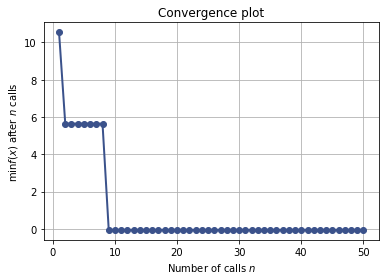

In [29]:
from skopt.plots import plot_convergence

plot_convergence(res_gp);

In [30]:
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64),
 array([ 1171, 31249, 16015,  2712,  1279, 10347,  1482,  2270,  2377,
          495], dtype=int64))

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(X)

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,10)

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette("BrBG", len(a))[x] for x in labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);

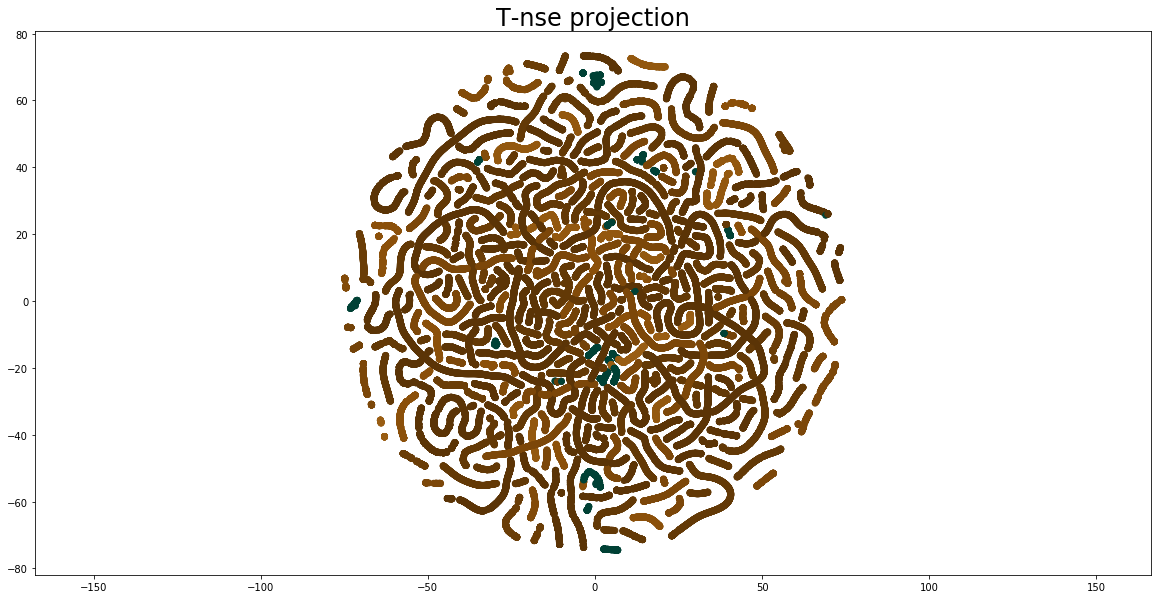

In [126]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[sns.color_palette("BrBG", len(a))[x] for x in labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('T-nse projection', fontsize=24);

### convert files to Strings

In [31]:
result=result.merge(no_dups[['QR','RS','ST','labels']], how='left')

In [32]:
result['lab']=result.labels.map(lambda x: chr(98+x))

In [51]:
results_agg=result.groupby('filename').agg({'lab':lambda x: x.sum()}).reset_index()

In [53]:
results_agg.head()

,filename,lab
0,./data/processed.old/107-113-p000107-2121-11-3...,bbcccbbbbbbbbcbbbbbbbbbbbcbbbbbbcbbbbbbcbcbcbc...
1,./data/processed.old/109-129-p000109-2141-10-2...,bbfbbbbbbbbbbbbbbbbcbbbbbbbbbbbbbbbbbbbbbbbbbb...
2,./data/processed.old/109-148-p000109-2142-08-1...,bbbbbbbbbbbbbbbbbbbbcbbbbbbbbbbbbbbbbbbbbbbbbb...
3,./data/processed.old/123-165-p000123-2161-10-2...,bbfbfbbbbbbbbffbbbfbbfbbbbbfbfbbfbbbbbbbbbfbbb...
4,./data/processed.old/124-169-p000124-2166-01-2...,bbbfbbbbfbbfffbbbbbbbfbbbbbfbbfbbbbbbbbbbbbbbb...


In [54]:
from nltk.tokenize import RegexpTokenizer

In [55]:
from nltk.util import ngrams

In [56]:
from collections import Counter

In [57]:
tokenizer = RegexpTokenizer('\S')

In [60]:
phrase_counter = Counter()
for l in results_agg.lab:
    tokens=tokenizer.tokenize(l)
    for phrase in ngrams(tokens, 2):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 3):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 4):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 5):
        phrase_counter[phrase] += 1    

In [62]:
phrase_counter.most_common(1000)

[(('b', 'b'), 208507),
 (('b', 'b', 'b'), 163038),
 (('b', 'b', 'b', 'b'), 132236),
 (('b', 'b', 'b', 'b', 'b'), 110261),
 (('c', 'b'), 44155),
 (('b', 'c'), 43968),
 (('c', 'c'), 36468),
 (('c', 'b', 'b'), 27598),
 (('b', 'b', 'c'), 27521),
 (('b', 'c', 'b'), 27102),
 (('f', 'b'), 22453),
 (('b', 'f'), 22431),
 (('c', 'c', 'c'), 18257),
 (('b', 'b', 'c', 'b'), 18201),
 (('b', 'c', 'b', 'b'), 18112),
 (('c', 'b', 'b', 'b'), 18104),
 (('b', 'b', 'b', 'c'), 18034),
 (('b', 'c', 'c'), 15498),
 (('c', 'c', 'b'), 15457),
 (('f', 'b', 'b'), 15418),
 (('b', 'b', 'f'), 15403),
 (('b', 'f', 'b'), 15332),
 (('c', 'b', 'c'), 14945),
 (('f', 'f'), 14159),
 (('b', 'b', 'c', 'b', 'b'), 12864),
 (('c', 'b', 'b', 'b', 'b'), 12684),
 (('b', 'b', 'b', 'b', 'c'), 12628),
 (('b', 'b', 'b', 'c', 'b'), 12544),
 (('b', 'c', 'b', 'b', 'b'), 12498),
 (('b', 'b', 'f', 'b'), 11377),
 (('b', 'f', 'b', 'b'), 11368),
 (('b', 'b', 'b', 'f'), 11243),
 (('f', 'b', 'b', 'b'), 11238),
 (('c', 'c', 'c', 'c'), 10007),
 ((

In [65]:
results_agg.shape

(30, 2)